In [1]:
import math, random
import numpy as np
import cvxpy as cv
import matplotlib.pyplot as plt
import scipy

# Setup

- import packages
- define simulation of data for bounds

In [6]:
def sample_path(x0, params, tmax, plot=False):
    """
    Simulate sample path of birth death reaction

    x0 = initial state
    params = [k1, k2]
    tmax = time of simulation

    return states visited and jump times
    """

    # parameters
    k1 = params[0]
    k2 = params[1]

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate until stopping time
    while t < tmax:

        # current state
        x = path[-1]

        # rates
        q_birth = k1
        q_death = k2 * x
        q_hold = q_birth + q_death

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        if u < q_birth / q_hold:
            path.append(x + 1)
        else:
            path.append(x - 1)

    if plot:
        plt.step(jump_times, path, where="post")

    return path, jump_times

In [7]:
def bootstrap(x_list, x0, params, tmax, n, N, plot=False, printing=False):
    """
    x_list = states to calculate probabilities for
    x0 = initial state
    params = [k1, k2]
    tmax = time until sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples
    states = []
    for i in range(n):
        path, jumps = sample_path(x0, params, tmax, plot=plot)
        states.append(path[-2])
    if plot:
        plt.show()

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

# Non-linear test

min/max k1

s.t. $ \sum Q^r k_r p = 0 $ 

$ p^l \le p \le p^u $

$ k _r \ge 0 $

But, without introducing $ z_r = k_r p $, the first constrant is non-linear, as multiply $ k_r $ and p, 2 variables, together. So this is no longer a linear program, and becomes a QCQP: quadratically constrained linear program

However, still have a linear objective and the non-linear terms are cross terms, somtimes called Bilinear program

### Problem: 

Not convex, as $ Q^r $ matrices are not symmetric, let alone PD or PSD, so have non-convex quadratically constrained problem.

### Approach 2:

use $ \sum Q^r z_r = 0 $ and define $ z_r = k_r p $ as a constraint

### But: still non-convex and non-linear constraint

In [17]:
# create confidence intervals
k1 = 2
x_max = 6
estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,1],100,1000,1000)

# create bounds on p
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]

# number of equations used)
N = 4

# create Qr matrices
Q1 = (np.diag([-1 for x in range(0,N+1)],0) + np.diag([1 for x in range(0,N)],-1))[:-1, :]
Q2 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]

# define bounds 
pl = np.array(pl)[:N + 1]
pu = np.array(pu)[:N + 1]

# Construct the problem.
k1 = cv.Variable(1)
k2 = 1
p = cv.Variable(N + 1)
z1 = cv.Variable(N + 1)
z2 = cv.Variable(N + 1)
objective_max = cv.Maximize(k1)
objective_min = cv.Minimize(k1)
constraints = [Q1 @ z1 + Q2 @ z2 == 0,
                k1 >= 0,
                p >= pl,
                p <= pu,
                z1 == k1 * p,
                z2 == k2 * p
                ]
prob_max = cv.Problem(objective_max, constraints)
prob_min = cv.Problem(objective_min, constraints)   

# Print result.
result_max = prob_max.solve()
print("\nThe upper bound is", prob_max.value)
print("A solution k1 is")
print(k1.value)
max_bound = k1.value
result_min = prob_min.solve()
print("\nThe lower bound is", prob_min.value)
print("A solution k1 is")
print(k1.value)
min_bound = k1.value

print(min_bound, max_bound)

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
var272 == Promote(var270, (5,)) @ var271 , because the following subexpressions are not:
|--  Promote(var270, (5,)) @ var271

# Scipy

### Example problem

max z = x + 2y \
s.t. 2x + y <= 20 \
     -4x + 5y <= 10 \
     -x + 2y >= -2 \
     -x + 5y = 15 \
     x >= 0 \
     y >= 0 

(note: convert constraints to >= 0, or = 0)

In [17]:
# Objective
obj = lambda x: x[0] + 2 * x[1]

# Constraints
cons = ({'type':'ineq', 'fun': lambda x: -2 * x[0] - x[1] + 20},
        {'type':'ineq', 'fun': lambda x: 4 * x[0] - 5 * x[1] + 10},
        {'type':'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2},
        {'type':'eq', 'fun': lambda x: -x[0] + 5 * x[1] - 15})

# bounds
bnds = ((0, None), (0, None))

# solve
res = scipy.optimize.minimize(obj, (0,0), method="SLSQP", bounds=bnds,constraints=cons)

# print
print(res.x)

[1.66666667 3.33333333]


### Birth Death

x = [k1, p0, p1, ...], k2 = 1 fixed

Using non-linear constraints, as k1 * p involved in stationary condition

In [79]:
N = 3

# create confidence intervals
k1 = 2
x_max = 6
estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,1],100,1000,1000)

# create Qr matrices
Q1 = (np.diag([-1 for x in range(0,N+1)],0) + np.diag([1 for x in range(0,N)],-1))[:-1, :]
Q2 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]

# create bounds on p
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]

# define bounds 
pl = np.array(pl)[:N + 1]
pu = np.array(pu)[:N + 1]

# Objective
obj_min = lambda x: x[0]
obj_max = lambda x: -x[0]

# Constraints
cons = ({'type':'eq', 'fun': lambda x: x[0] * Q1 @ x[1:] + Q2 @ x[1:]})

# Bounds
bnds = ((0, None),) + tuple([(lb, ub) for lb, ub in zip(pl, pu)])

# initial value
x0 = tuple([0 for x in range(N + 2)])

# solve
res_min = scipy.optimize.minimize(obj_min, x0, method="SLSQP", bounds=bnds,constraints=cons)
res_max = scipy.optimize.minimize(obj_max, x0, method="SLSQP", bounds=bnds,constraints=cons)

# print
k1_lb = res_min.x[0]
k1_ub = res_max.x[0]
p_lb = res_min.x[1:]
p_ub = res_max.x[1:]
print(f"k1 in: ({k1_lb}, {k1_ub})")

k1 in: (1.8791592733200484, 2.2789744037360102)


Seems to perform very well, obtaining tight and accurate (95% CI bounds so sometimes off) bounds on k1

# Gene Expression Model

# Setup

In [3]:
def sample_path_gene(initial_state, params, tmax, plot=False):
    """
    Simulate a sample path of gene expression
    start at initial state, run until time tmax, rates in params
    return visited states and jump times
    """

    # initialise time and state (also store jump times)
    t = 0
    path = [(initial_state[0],initial_state[1])]
    jump_times = [0]
    k_on, k_off, k_tx, k_deg = params[0], params[1], params[2], params[3]

    # simulate until stopping time
    while t < tmax:
        # simulate holding time of current state (m,g)
        m, g = path[-1][0], path[-1][1]

        # define rates
        # q(x,x+(0,1)): gene turns on if off
        q_on = (1 - g) * k_on
        # q(x,x+(0,-1)): gene turns off if on
        q_off = g * k_off
        # q(x,x+(1,0)): transscription if gene on
        q_tx = g * k_tx
        # q(x,x+(-1,0)): degradation if  there are molecules
        q_deg = m * k_deg
        # -q(x,x): holding rate = sum q(x,y) over y
        q_hold = q_on + q_off + q_tx + q_deg

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        # P(x -> y) = q_xy / q_hold
        outcome = [1,2,3,4]
        prob = [q_on / q_hold, q_off / q_hold, q_tx / q_hold, q_deg / q_hold]
        jump = np.random.choice(outcome,p=prob)
        # jump to new state
        if jump == 1:
            path.append((m,g + 1))
        elif jump == 2:
            path.append((m,g - 1))
        elif jump == 3:
            path.append((m + 1,g))
        elif jump == 4:
            path.append((m - 1,g))

    if plot:
        # separate paths
        m_path = [state[0] for state in path]
        g_path = [state[1] for state in path]
        plt.scatter(jump_times, m_path, c=g_path, ec='k')

        # defined colour plotting
        #cmap, norm = mcolors.from_levels_and_colors([0, 1, 2], ['orange','blue'])
        #plt.scatter(jump_times, m_list, c=g_list, cmap=cmap, norm=norm)

    return path, jump_times

In [4]:
def bootstrap_marginal(m_list, initial_state, params, tmax, n, N, plot=False, printing=False):
    """
    m_list: marginal states of m to calculate probabilities for
    initial state
    parameters
    tmax: time of path before sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples: (m,g)
    states = []
    for i in range(n):
        path, jumps = sample_path_gene(initial_state, params, tmax, plot=plot)
        states.append(path[-2]) # last state before tmax
    plt.show()

    # simulate N bootstrap samples: estimates p(m) for each, and for each m
    estimates = [[] for x in m_list]
    for i in range(N):
        # sample with replacement from (m,g) samples
        sample = random.choices(states,k = n)
        # take just marginal m information
        m_sample = [state[0] for state in sample]
        # estimate p(m) from marginal info
        for i, x in enumerate(m_list):
            estimates[i].append(m_sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(m_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

# Non-linear program

x = [k1, k2, k3, k4, p(0,0), p(0,1), ... ]

i.e. x[4:] = p (joint probability vector)

In [5]:
# number of equations used
N = 4
# number of marginals used
M = int(N/2 + 1)
# parameters
k1, k2, k3, k4 = 1, 1 ,0.5, 1
# # number of marginal simulated (needs to be > M )
x_max = 10

# simulate data
states = [x for x in range(x_max)]
estimates_marginal, intervals_marginal = bootstrap_marginal(states,[0,0],[k1,k2,k3,k4],100,2000,2000,plot=False,printing=True)

# bounds from CI, on marginal
pl = [intr[0] for intr in intervals_marginal]
pu = [intr[1] for intr in intervals_marginal]

# define bounds
pl = np.array(pl)[:M]
pu = np.array(pu)[:M]

# marginal = A @ p
A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

# create Qr matrices
Q1 = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
        np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
Q2 = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
        np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
Q3 = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
        np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
Q4 = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
        np.diag([1 for x in range(0,N)],2))[:-2, :]

# Objective (k3)
obj_min = lambda x: x[2]
obj_max = lambda x: -x[2]

# Constraints
cons = ({'type':'eq', 'fun': lambda x: x[0] * Q1 @ x[4:] + x[1] * Q2 @ x[4:] + x[2] * Q3 @ x[4:] + x[3] * Q4 @ x[4:]},
        {'type':'ineq', 'fun': lambda x: A @ x[4:] - pl},
        {'type':'ineq', 'fun': lambda x: pu - A @ x[4:]})

# Bounds: 4 rates, (N + 2) length p
bnds = ((0, None),(0, None),(0, None),(0, None)) + tuple([(0,1) for i in range(N + 2)])
#tuple([(lb, ub) for lb, ub in zip(pl, pu)]) (change to frechet bounds??)

# initial value: 4 rates, (N + 2) length p
x0 = tuple([0.5 for x in range(N + 6)])

# solve
res_min = scipy.optimize.minimize(obj_min, x0, method="SLSQP", bounds=bnds,constraints=cons)
res_max = scipy.optimize.minimize(obj_max, x0, method="SLSQP", bounds=bnds,constraints=cons)

# print
k3_lb = res_min.x[2]
k3_ub = res_max.x[2]
p_lb = res_min.x[4:]
p_ub = res_max.x[4:]
print(f"k3 in: ({k3_lb}, {k3_ub})")
print(res_min.x)
print(res_max.x)

95% CI for p(0) is: (0.768, 0.8040125)
95% CI for p(1) is: (0.1645, 0.1985)
95% CI for p(2) is: (0.0225, 0.037)
95% CI for p(3) is: (0.0005, 0.005)
95% CI for p(4) is: (0.0, 0.0)
95% CI for p(5) is: (0.0, 0.0)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)
k3 in: (4.877586287204685e-17, 0.2895202418901774)
[3.72836770e-01 6.12853242e-01 4.87758629e-17 8.97914680e-17
 4.99894075e-01 3.04116678e-01 1.02707894e-01 6.24836043e-02
 3.64508674e-02 5.72961490e-07]
[1.53085503e+00 3.17264509e-01 2.89520242e-01 1.08366840e+00
 1.55834071e-01 6.37795636e-01 3.15065149e-02 1.37746549e-01
 3.65209176e-02 4.34892297e-13]


In [77]:
def gene_optimize(N, intervals, x0=None, k1=None, k2=None, k3=None, k4=None):
    """
    N: number of equations to use
    intervals: CI's on stationary distribution of marginals
    x0: initial value for [k1, k2, k3, k4]
    k1, k2, k3, k4: option to fix parameter values (should fix at least 1)
    """
    # number of marginals used (need > M marginal CI's)
    M = int(N/2 + 1)

    # bounds from CI, on marginal
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds
    pl = np.array(pl)[:M]
    pu = np.array(pu)[:M]

    # marginal = A @ p
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

    # create Qr matrices
    Q1 = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
            np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q2 = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
            np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q3 = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
            np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    Q4 = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
            np.diag([1 for x in range(0,N)],2))[:-2, :]

    # Constraints
    cons = ({'type':'eq', 'fun': lambda x: x[0] * Q1 @ x[4:] + x[1] * Q2 @ x[4:] + x[2] * Q3 @ x[4:] + x[3] * Q4 @ x[4:]},
            {'type':'ineq', 'fun': lambda x: A @ x[4:] - pl},
            {'type':'ineq', 'fun': lambda x: pu - A @ x[4:]})
    # fix variables
    if k1:
        cons + ({'type':'eq', 'fun': lambda x: x[0] - k1},)
    if k2:
        cons + ({'type':'eq', 'fun': lambda x: x[1] - k2},)
    if k3:
        cons + ({'type':'eq', 'fun': lambda x: x[2] - k3},)
    if k4:
        cons + ({'type':'eq', 'fun': lambda x: x[3] - k4},)

    # Bounds: 4 rates, (N + 2) length p
    bnds = ((0, 10),(0, 10),(0, 10),(0, 10)) + tuple([(0,1) for i in range(N + 2)])
    #tuple([(lb, ub) for lb, ub in zip(pl, pu)]) (change to frechet bounds??)

    # initial value: 4 rates, (N + 2) length p
    if not x0:
        x0 = (0.1 if not k1 else k1, 0.1 if not k2 else k2, 0.1 if not k3 else k3, 0.1 if not k4 else k4) + tuple([0 for x in range(N + 2)])
    else:
        x0 = x0 + tuple([0 for x in range(N + 2)])

    # solution
    solutions = []

    # loop over rates
    for i in range(4):
        # Objective: k1, k2, k3, k4
        obj_min = lambda x: x[i]
        obj_max = lambda x: -x[i]

        # solve
        res_min = scipy.optimize.minimize(obj_min, x0, method="SLSQP", bounds=bnds, constraints=cons)
        res_max = scipy.optimize.minimize(obj_max, x0, method="SLSQP", bounds=bnds, constraints=cons)

        # store
        lb = res_min.x[i]
        ub = res_max.x[i]
        solutions.append((lb, ub))
        print(f"k{i + 1} in ({lb} , {ub})")

    return solutions

In [7]:
# set parameters
k1, k2, k3, k4 = 1, 1 ,0.5, 1

# set number of marginal simulated (needs to be > M )
x_max = 10

# simulate data with parameters
states = [x for x in range(x_max)]
estimates_marginal, intervals_marginal = bootstrap_marginal(states,[0,0],[k1,k2,k3,k4],100,2000,2000,plot=False,printing=True)

95% CI for p(0) is: (0.7475, 0.783)
95% CI for p(1) is: (0.1815, 0.2165)
95% CI for p(2) is: (0.023, 0.038)
95% CI for p(3) is: (0.002, 0.0075)
95% CI for p(4) is: (0.0, 0.0)
95% CI for p(5) is: (0.0, 0.0015)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)


In [56]:
# solve using data, fixing parameters
solutions = gene_optimize(8, intervals_marginal, k1 = 1, k2 = 1, k4 = 1)

k1 in (0.9900000012039708 , 2.0745431125787337)
k2 in (5.5236209774388835e-06 , 1.000462263981537)
k3 in (0.09851024684902739 , 1.1000008525924687)
k4 in (0.9999999999050767 , 2.0016669012465136)


k1 in (0.9999999985298105 , 2.017941915721175)
k2 in (2.270432008751487e-06 , 1.0000000065117125)
k3 in (0.0 , 1.332225226549784)
k4 in (0.9999999998051011 , 2.0035236386934456)
k1 in (0.9999999989207952 , 2.0880019754551737)
k2 in (1.4357194859854677e-10 , 1.0000000049602586)
k3 in (0.09801001243869481 , 1.1212230040787552)
k4 in (0.9999999995516877 , 2.0008178617945047)
k1 in (0.0 , 1.0310323259370766)
k2 in (0.0 , 4.504059905556393e-12)
k3 in (0.3009914043651134 , 10.0)
k4 in (1.7330456267436225 , 0.0)
k1 in (3.082905851718374 , 0.0)
k2 in (4.329133991339155 , 0.0)
k3 in (0.5781077855463007 , 6.000855962869207)
k4 in (9.364095969331117 , 2.5317954231105193)
k1 in (0.0 , 0.0)
k2 in (1.6477906299481502 , 2.2987157884684395)
k3 in (1.5961360413749683 , 0.0)
k4 in (9.998377803400148 , 3.095625392040924)
k1 in (0.9971150328116837 , 2.100405168424148)
k2 in (1.1551664091861665e-05 , 1.0001000414260008)
k3 in (0.08910000180082081 , 2.1031022887650925)
k4 in (0.9999999999052842 , 2.00142558

ValueError: x and y must be the same size

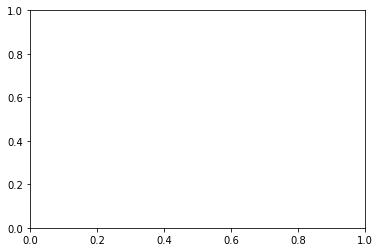

In [65]:
lbs = []
ubs = []
for n in range(20):
    # simulate data
    est_test, int_test = bootstrap_marginal([x for x in range(10)],[0,0],[k1,k2,k3,k4],100,2000,2000)
    # solve
    solutions = gene_optimize(8, int_test, k1 = 1, k2 = 1, k4 = 1)
    lb = solutions[2][0]
    ub = solutions[2][1]
    lbs.append(lb)
    ubs.append(ub)

plt.scatter(lbs, [1 for x in range(10)])
plt.scatter(ubs, [2 for x in range(10)])
plt.axvline(0.5, color="red")

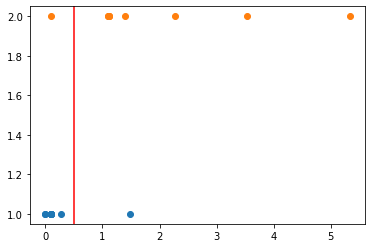

In [64]:
plt.scatter(lbs, [1 for x in range(10)])
plt.scatter(ubs, [2 for x in range(10)])
plt.axvline(0.5, color="red")

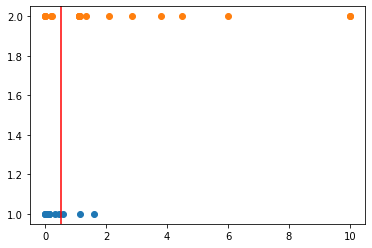

In [66]:
plt.scatter(lbs, [1 for x in range(20)])
plt.scatter(ubs, [2 for x in range(20)])
plt.axvline(0.5, color="red")

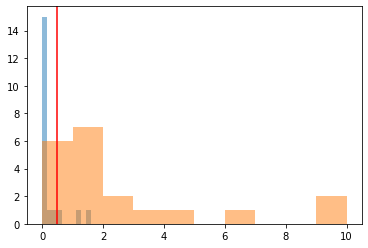

In [71]:
plt.hist(lbs, alpha=0.5)
plt.hist(ubs, alpha=0.5)
plt.axvline(0.5, color="red")

k1 in (4.7071344164866495 , 6.111286358778389)
k2 in (9.999446496141207 , 9.97592644257281)
k3 in (0.7404412047752684 , 1.5110395714398333)
k4 in (6.4268410545396195 , 7.518475179032463)
k1 in (7.26190907364651 , 9.999999996943817)
k2 in (0.0 , 10.0)
k3 in (1.1931087457686163 , 0.0)
k4 in (6.099275002719288 , 0.0)
k1 in (6.594459972438249 , 9.999999999999998)
k2 in (0.8896356193954239 , 4.31482360148417)
k3 in (0.2200459038717452 , 0.5776017652322025)
k4 in (2.4761893984912355e-10 , 4.074129132839909)
k1 in (8.589136404446329 , 10.0)
k2 in (9.054528198374116e-11 , 0.0)
k3 in (3.829616380402667 , 1.9688618478267588)
k4 in (4.795003903771564 , 9.068039811905575)
k1 in (0.0 , 9.999999998809614)
k2 in (0.0 , 10.0)
k3 in (0.0 , 2.2192287590117696)
k4 in (2.0161687633667298e-08 , 9.575868842025493)
k1 in (1.8042738312288715 , 4.069999165924837)
k2 in (2.0691009090300927 , 1.468849947350714)
k3 in (0.9383653458171772 , 0.8523836784206296)
k4 in (1.107799730050037 , 1.647089873629087e-12)
k1 i

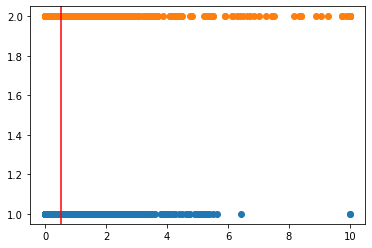

In [99]:
lbs = []
ubs = []
# set parameters
k1, k2, k3, k4 = 1, 1 ,0.5, 1
# simulate data
est_test, int_test = bootstrap_marginal([x for x in range(10)],[0,0],[k1,k2,k3,k4],100,2000,2000)
# number of random intialisations
N = 500
for n in range(N):
    k3 = np.random.uniform(0.1, 5)
    x0 = (1, 1, k3, 1)
    # solve
    solutions = gene_optimize(8, int_test, x0 = x0, k1 = 1, k2 = 1, k4 = 1)
    lb = solutions[2][0]
    ub = solutions[2][1]
    lbs.append(lb)
    ubs.append(ub)

plt.scatter(lbs, [1 for x in range(N)])
plt.scatter(ubs, [2 for x in range(N)])
plt.axvline(0.5, color="red")

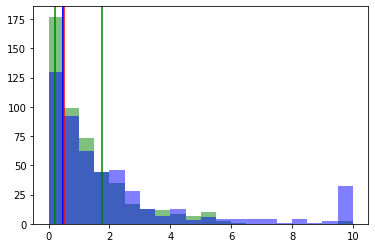

In [100]:
plt.hist(lbs, alpha=0.5, bins = 20, color = "green")
plt.hist(ubs, alpha=0.5, bins = 20, color="blue")
l1, l2 = np.quantile(lbs,[0.25,0.75])
u1, u2 = np.quantile(ubs,[0.25,0.75])
plt.axvline(np.mean(l1),color="green")
plt.axvline(np.mean(l2),color="green")
plt.axvline(np.mean(u1),color="blue")
plt.axvline(np.mean(u1),color="blue")
plt.axvline(0.5, color="red")

# Attempt other solvers

In [72]:
def gene_optimize_2(N, intervals, k1=None, k2=None, k3=None, k4=None):
    """
    N: number of equations to use
    intervals: CI's on stationary distribution of marginals
    k1, k2, k3, k4: option to fix parameter values (should fix at least 1)
    """
    # number of marginals used (need > M marginal CI's)
    M = int(N/2 + 1)

    # bounds from CI, on marginal
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds
    pl = np.array(pl)[:M]
    pu = np.array(pu)[:M]

    # marginal = A @ p
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

    # create Qr matrices
    Q1 = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
            np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q2 = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
            np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q3 = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
            np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    Q4 = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
            np.diag([1 for x in range(0,N)],2))[:-2, :]

    # Constraints
    cons = (
        scipy.optimize.NonlinearConstraint(lambda x: x[0] * Q1 @ x[4:] + x[1] * Q2 @ x[4:] + x[2] * Q3 @ x[4:] + x[3] * Q4 @ x[4:], 0, 0),
        scipy.optimize.NonlinearConstraint(lambda x: A @ x[4:], pl, pu)
    )
    # fix variables
    if k1:
        cons + (lambda x: x[0], k1, k1)
    if k2:
        cons + (lambda x: x[1], k2, k2)
    if k3:
        cons + (lambda x: x[2], k3, k3)
    if k4:
        cons + (lambda x: x[3], k4, k4)

    # Bounds: 4 rates, (N + 2) length p
    bnds = ((0, 10),(0, 10),(0, 10),(0, 10)) + tuple([(0,1) for i in range(N + 2)])
    #tuple([(lb, ub) for lb, ub in zip(pl, pu)]) (change to frechet bounds??)

    # solution
    solutions = []

    # loop over rates
    for i in range(4):
        # Objective: k1, k2, k3, k4
        obj_min = lambda x: x[i]
        obj_max = lambda x: -x[i]

        # solve
        res_min = scipy.optimize.differential_evolution(obj_min, bounds=bnds, constraints=cons)
        res_max = scipy.optimize.differential_evolution(obj_max, bounds=bnds, constraints=cons)

        # store
        lb = res_min.x[i]
        ub = res_max.x[i]
        solutions.append((lb, ub))
        print(f"k{i + 1} in ({lb} , {ub})")

    return solutions

In [73]:
# set parameters
k1, k2, k3, k4 = 1, 1 ,0.5, 1

# set number of marginal simulated (needs to be > M )
x_max = 10

# simulate data with parameters
states = [x for x in range(x_max)]
estimates_marginal, intervals_marginal = bootstrap_marginal(states,[0,0],[k1,k2,k3,k4],100,2000,2000,plot=False,printing=True)

95% CI for p(0) is: (0.7784875, 0.8135125)
95% CI for p(1) is: (0.1595, 0.1925)
95% CI for p(2) is: (0.0185, 0.032)
95% CI for p(3) is: (0.001, 0.0055)
95% CI for p(4) is: (0.0, 0.0015)
95% CI for p(5) is: (0.0, 0.0)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)


In [74]:
# solve using data, fixing parameters
solutions = gene_optimize_2(4, intervals_marginal, k1 = 1, k2 = 1, k4 = 1)

c:\Users\willi\principles_of_programming\PoP_venv\lib\site-packages\scipy\optimize\_differentialevolution.py:898: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  warnings.warn("differential evolution didn't find a"
c:\Users\willi\principles_of_programming\PoP_venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


k1 in (0.0001226239038602579 , 9.999999948776066)
k2 in (5.1273270486741275e-08 , 9.999999957598336)
k3 in (1.0305842685609173e-07 , 2.4661406235336325)
k4 in (9.201584273381505e-09 , 9.99999973729411)


In [75]:
# solve using data, fixing parameters
solutions = gene_optimize_2(6, intervals_marginal, k1 = 1)

k1 in (1.0478196240661452e-06 , 1.4369098055124399)
k2 in (5.1196165885837876e-08 , 0.5678331446668388)
k3 in (0.18422299967179967 , 2.0465223213355563)
k4 in (9.012201814766082e-09 , 3.9734276917453926)


# Gurobi

Using cvxpy allows different solvers to be passed as an option when solving

In [4]:
# Example problem
x = cv.Variable(2)
obj = cv.Minimize(x[0] + x[1])
constraints = [x >= 2]
prob = cv.Problem(obj, constraints)

# Solve with GUROBI.
prob.solve(solver=cv.GUROBI)
print("optimal value with GUROBI:", prob.value)

optimal value with GUROBI: 4.0


However, cvxpy only supports convex optimization problems and without linearising the problems are not convex. Need to implement directly through the Gurobi python API

In [2]:
import gurobipy as gp
from gurobipy import GRB

In [13]:
# create a model
m = gp.Model("model1")

# create variables
x = m.addVar(vtype=GRB.BINARY, name="x")
y = m.addVar(vtype=GRB.BINARY, name="y")

# add constraints
m.addConstr(x + 2 * y <= 4, name="c0")
m.addConstr(x + y <= 1, name="c1")

# set objective
m.setObjective(x + 2 * y + 2, sense=GRB.MAXIMIZE)

# optimize (solve)
m.optimize()

# get variables: name, value
for v in m.getVars():
    print(f"{v.VarName} = {v.X}")
# get objective value
print(f"Objective = {m.ObjVal}")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0xb31f5e4a
Variable types: 0 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 2 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 4 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+00, best bound 4.000000000000e+00, gap 0.0000%
x = 0.0
y = 1.0
Objective = 4.0


## Matrix variables and constraints:

In [22]:
# create a model
m = gp.Model("model2")

# create vector variable
x = m.addMVar(shape=3, vtype=GRB.CONTINUOUS, name="x")

# create matrix constraint
A = np.array([[1.0, 2.0, 1.0], [2.0, 1.0, 1.0]])
b = np.array([1.0, 2.0])
m.addConstr(A @ x <= b, name="c")

# create objective
v = np.array([1.0, 1.0, 2.0])
m.setObjective(v @ x, GRB.MAXIMIZE)

# optimize (solve)
m.optimize()

# get variable: name, value
for v in m.getVars():
    print(f"{v.VarName} = {v.X}")
# get objective value
print(f"Objective = {m.ObjVal}")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 3 columns and 6 nonzeros
Model fingerprint: 0xaf01f4f9
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve time: 0.03s
Presolved: 2 rows, 3 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0000000e+30   5.000000e+30   6.000000e+00      0s
       1    2.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds (0.00 work units)
Optimal objective  2.000000000e+00
x[0] = 0.0
x[1] = 0.0
x[2] = 1.0
Objective = 2.0


## Modify program after solution: change objective, min to max, etc

In [24]:
# create a model
m = gp.Model("model3")

# create variables
x = m.addVar(vtype=GRB.BINARY, name="x")
y = m.addVar(vtype=GRB.BINARY, name="y")

# add constraints
m.addConstr(x + y <= 3, name="c")

# set objective
m.setObjective(x, sense=GRB.MAXIMIZE)

# optimize (solve)
m.optimize()

# get variables: name, value
for v in m.getVars():
    print(f"{v.VarName} = {v.X}")
# get objective value
print(f"Objective = {m.ObjVal}")

# change objective
m.setObjective(y, sense=GRB.MAXIMIZE)

# optimize (re-solve)
m.optimize()

# get variables: name, value
for v in m.getVars():
    print(f"{v.VarName} = {v.X}")
# get objective value
print(f"Objective = {m.ObjVal}")


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 2 columns and 2 nonzeros
Model fingerprint: 0x3d3b37f7
Variable types: 0 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+00]
Found heuristic solution: objective 1.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
x = 1.0
y = -0.0
Objective = 1.0
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Co

# Debugging gene expression issues

Create true stationary distribution values for use as intervals

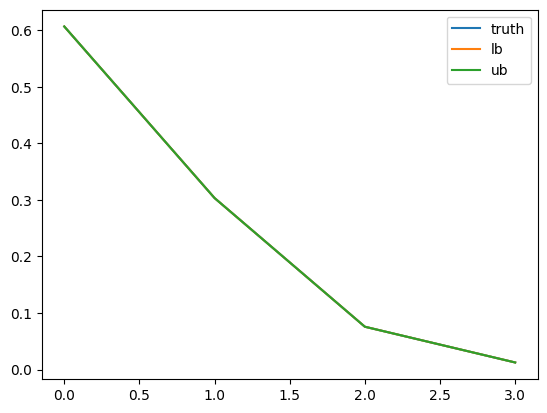

In [134]:
# parameters
k_on = 1
k_off = 0
k_tx = 0.5
k_deg = 1

# true stationary distribution: reduces to birth death case (gene always on) so poisson(k_tx / k_deg)
# number of marginal states to use
M = 4
# then N = 2M - 2 equations (involve all these marginals and no more)
N = 2*M - 2
true_p = [(k_tx / k_deg)**k * math.exp(-k_tx / k_deg) / math.factorial(k) for k in range(M)]

# create intervals: some error around truth
eps = 0
pl = np.array([p - eps for p in true_p])
pu = np.array([p + eps for p in true_p])

# plot
plt.plot(true_p, label="truth")
plt.plot(pl, label="lb")
plt.plot(pu, label="ub")
plt.legend()
plt.show()

In [146]:
# take bounds as uninformative
pl = np.array([0. for k in range(M)])
pu = np.array([1. for k in range(M)])

In [147]:
# create Qr matrices:
# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
# gives N x N + 2 matrices
Q_on = (np.diag([-1. if not x % 2 else .0 for x in range(0,N+2)],0) +
        np.diag([1. if not x % 2 else .0 for x in range(0,N+1)],-1))[:-2, :]
Q_off = (np.diag([-1. if x % 2 else .0 for x in range(0,N+2)],0) +
        np.diag([1. if not x % 2 else .0 for x in range(0,N+1)],1))[:-2, :]
Q_tx = (np.diag([-1. if x % 2 else .0 for x in range(0,N+2)],0) +
        np.diag([1. if x % 2 else .0 for x in range(0,N)],-2))[:-2, :]
Q_deg = (np.diag([-1. if x > 1 else .0 for x in range(0,N+2)],0) +
        np.diag([1. for x in range(0,N)],2))[:-2, :]

print(f"Q_on = \n{Q_on}")
print(f"Q_off = \n{Q_off}")
print(f"Q_tx = \n{Q_tx}")
print(f"Q_deg = \n{Q_deg}")

# form doubled bounds
#pdl = np.repeat(pl,2)
#pdu = np.repeat(pu,2)

# marginal = A @ p
A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

print(f"A = \n{A}")

# create model
m = gp.Model("gene_exp")

# m.Params.LogToConsole = 0

# set options
# m.setParam('MIPGap', 0.0)
m.setParam('MIPFocus', 1.0)

# add variable p in [0, 1]
p = m.addMVar(shape=N + 2, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

# create reaction variables (or leave as constants)
K = 100
#k_on = m.addVar(vtype=GRB.CONTINUOUS, name="k_on", lb=0, ub=K)
#k_off = m.addVar(vtype=GRB.CONTINUOUS, name="k_off", lb=0, ub=K)
k_tx = m.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
#k_deg = m.addVar(vtype=GRB.CONTINUOUS, name="k_deg", lb=0, ub=K)

# Constraints:
# Stationary condition: Qp = 0
m.addConstr(k_on*(Q_on @ p) + k_off*(Q_off @ p) + k_tx*(Q_tx @ p) + k_deg*(Q_deg @ p) == 0, name="Qp=0")
# m.addConstr(k_on*(Q_on @ p) + k_off*(Q_off @ p) + k_tx*(Q_tx @ p) + k_deg*(Q_deg @ p) <= 0, name="Qp<=0")
# m.addConstr(0 <= k_on*(Q_on @ p) + k_off*(Q_off @ p) + k_tx*(Q_tx @ p) + k_deg*(Q_deg @ p), name="Qp=>0")
# marginal bounds: p_L <= A @ p <= p_U
m.addConstr(pl <= A @ p, name="Marginal lb")
m.addConstr(A @ p <= pu, name="Marginal ub" )
# m.addConstr(A @ p == pl, name="exact test")
# m.addConstr(p == joint, name="exact test")
# truncated joint dist: sum(p) <= 1
m.addConstr(p.sum() <= 1, name="Joint dist")

'''
# frechet lower bounds (assume upper redundant)
# [k_on, k_off, k_on, k_off, ...]
kv1 = np.array([0 if x % 2 else 1 for x in range(N + 2)])
kv2 = np.array([1 if x % 2 else 0 for x in range(N + 2)])
kv = k_on * kv1 + k_off * kv2
# m.addConstr(p <= np.ones(N + 2) - (1 / (k_on + k_off)) * kv)
# m.addConstr(p >= pdl - (1 / (k_on + k_off)) * kv)
m.addConstr((k_on + k_off) * p <= (k_on + k_off) * np.ones(N + 2) - kv)
m.addConstr((k_on + k_off) * p >= (k_on + k_off) * pdl - kv)
'''

# objective
m.setObjective(k_tx, GRB.MINIMIZE)
#m.setObjective(1, GRB.MINIMIZE)


try:
    # optimize (solve)
    m.optimize()
    # record
    min_val = m.ObjVal
except:
    # record as infeasible/unbounded
    min_val = None

# reset
m.reset()

# change objective
m.setObjective(k_tx, GRB.MAXIMIZE)
#m.setObjective(1, GRB.MAXIMIZE)


try:
    # re-optimize (re-solve)
    m.optimize()
    # record
    max_val = m.ObjVal
except:
    # record as infeasible/unbounded
    max_val = None

# print
print(f"k_tx in ({min_val}, {max_val})")

Q_on = 
[[-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]]
Q_off = 
[[ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]]
Q_tx = 
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0. -1.  0.  0.]]
Q_deg = 
[[ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  1.]]
A = 
[[1 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1 1]]
Set parameter MIPFocus to value 1
Gurobi

In [130]:
iis = m.computeIIS()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


IIS computed: 7 constraints, 4 bounds
IIS runtime: 0.00 seconds (0.00 work units)


In [133]:
m.write("out.ilp")

In [125]:
for i in range(0, len(p.X), 2):
    print(p.X[i] + p.X[i+1])

0.36787944117144233
0.36787944117144233
0.18393972058572117
0.06131324019524039
0.015328310048810098
0.0030656620097620196
0.0005109436682936699
7.299195261338141e-05
9.123994076672677e-06
1.0137771196302974e-06


In [121]:
p.X

array([0.36787944, 0.        , 0.36787944, 0.        , 0.18393972,
       0.        , 0.06131324, 0.        ])

In [90]:
true_p

[0.36787944117144233,
 0.36787944117144233,
 0.18393972058572117,
 0.06131324019524039]